In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import pandas as pd
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap
import numpyro
from numpyro import distributions as dist
from numpyro import infer
from numpyro_ext import distributions as distx
from numpyro_ext import info, optim
numpyro.set_host_device_count(1)  # For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_platform("cpu")  # For CPU (use "gpu" for GPU)
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

#jax.config.update('jax_disable_jit', True)
from jaxoplanet import light_curves, orbits
from jaxoplanet.orbits.keplerian import Central, Body, System
from jaxoplanet.units import unit_registry as ureg
from jaxoplanet import units
from matplotlib import rc
from astropy.table import Table
rc('font', **{'family':'sans-serif'})
rc('text', usetex=False)
rc('xtick', **{'top':True, 'direction':'in', 'major.width':1.0, 'minor.width':1.0})
rc('ytick', **{'right':True, 'direction':'in', 'major.width':1.0, 'minor.width':1.0})
rc('lines', **{'markeredgewidth':1.0})

yr = 365.25

## Pulling in the Hipparcos data
First, we get the single star solution as well as the epoch astrometry from the Intermediate Astrometry Data (IAD), available at [here](https://www.cosmos.esa.int/web/hipparcos/hipparcos-2) courtesy of Van Leeuwen and Michalik (2021). The IAD `EPOCH` column is the time in decimal years with the reference time 1991.25 subtracted. `PARF` is the parallax factor, `SPSI` is the sine of the scan angle, and `CPSI` is the cosine of the scan angle. `RES` lists the epoch astrometry with the single star solution subtracted from the data. `SRES` lists the error on those measurements.

In [20]:
header_name = 'RAdeg        DEdeg        Plx      pm_RA    pm_DE    e_RA   e_DE   e_Plx  e_pmRA e_pmDE dpmRA  dpmDE  e_dpmRA  e_dpmDE  ddpmRA  ddpmDE  e_ddpmRA  e_ddpmDE  upsRA   upsDE   e_upsRA  e_upsDE  var'.split()
full_data = pd.read_csv('/Users/shishir/Documents/Astronomy/USQ/PTV/alpha_pic_test/H032607.d',header=None,names=header_name,delim_whitespace=True,skiprows=lambda x: x != 10)
plx = float(full_data['Plx']*1e-3) #get the mean hipparcos parallax from the header data
pm_ra = float(full_data['pm_RA']*1e-3) #get the mean hipparcos pm_ra from the header data
pm_dec = float(full_data['pm_DE']*1e-3) #get the mean hipparcos pm_dec from the header data
del_ra = float(full_data['RAdeg'])
full_data
plx,pm_ra,pm_dec

/var/folders/4b/sq0slnz147sfy_kz1_nwf6zh0000gn/T/ipykernel_179/375909519.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plx = float(full_data['Plx']*1e-3) #get the mean hipparcos parallax from the header data
/var/folders/4b/sq0slnz147sfy_kz1_nwf6zh0000gn/T/ipykernel_179/375909519.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pm_ra = float(full_data['pm_RA']*1e-3) #get the mean hipparcos pm_ra from the header data
/var/folders/4b/sq0slnz147sfy_kz1_nwf6zh0000gn/T/ipykernel_179/375909519.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pm_dec = float(full_data['pm_DE']*1e-3) #get the mean hipparcos pm_dec from the header data


(0.033780000000000004, -0.06606999999999999, 0.24297)

In [21]:
header = 'IORB   EPOCH    PARF    CPSI    SPSI     RES   SRES'.split()
data = pd.read_csv('/Users/shishir/Documents/Astronomy/USQ/PTV/alpha_pic_test/H032607.d',header=None,names=header,delim_whitespace=True,comment='#')
data

IORB   EPOCH    PARF    CPSI    SPSI    RES   SRES
0     126 -1.2529  0.6682 -0.7110 -0.7032  -9.34  12.05
1     126 -1.2529  0.6665 -0.7121 -0.7021  -7.40  12.10
2     191 -1.1740 -0.6622 -0.3366  0.9417 -12.51  12.06
3     191 -1.1740 -0.6623 -0.3364  0.9417 -12.65  12.06
4     191 -1.1740 -0.6643 -0.3338  0.9427 -12.99  12.06
..    ...     ...     ...     ...     ...    ...    ...
97   2511  1.6447 -0.6780 -0.9981  0.0617 -11.92  12.05
98   2671  1.8390  0.6608 -0.9845 -0.1754 -25.49  12.06
99   2671  1.8390  0.6621 -0.9842 -0.1772 -24.19  12.06
100  2671  1.8390  0.6593 -0.9849 -0.1733 -23.31  12.06
101  2671  1.8390  0.6585 -0.9851 -0.1722 -23.64  12.06

[102 rows x 7 columns]

In [22]:
from astropy.time import Time
t = jnp.array(Time(jnp.array(data["EPOCH"]+1991.25).flatten(), format='decimalyear').jd)
#t = jnp.array() # time, BJD, TCB
t0 = Time(1991.25, format='decimalyear').jd # J1991.25
t -= t0
gof_ext = 0.07
w = jnp.array(data['RES']*1e-3) # along-scan position, arcsec
sres = jnp.array(data['SRES']) # uncertainty in the along-scan position, arcsec
DOF = len(t) - 6
disper_ext = 12.0

renorm_factor = (gof_ext * jnp.sqrt(2/(9*DOF)) + 1 - (2/(9*DOF)))**3
sig_w = renorm_factor * np.sqrt(sres**2 - disper_ext**2)*1e-3
pf = jnp.array(data['PARF']) # parallax factor

#psi = jnp.array(data.scan_pos_angle.values*jnp.pi/180) # scan position angle, radians
spsi = jnp.array(data['CPSI']) # sin of scan position angle
cpsi = jnp.array(data['SPSI']) # cos of scan position angle


In [23]:
fine_t = np.linspace(np.min(t),np.max(t),1000)
st = jnp.sin(2*jnp.pi*fine_t/yr)
ct = jnp.cos(2*jnp.pi*fine_t/yr)

Use the Hipparcos solution to compute the term to add back to the data below:

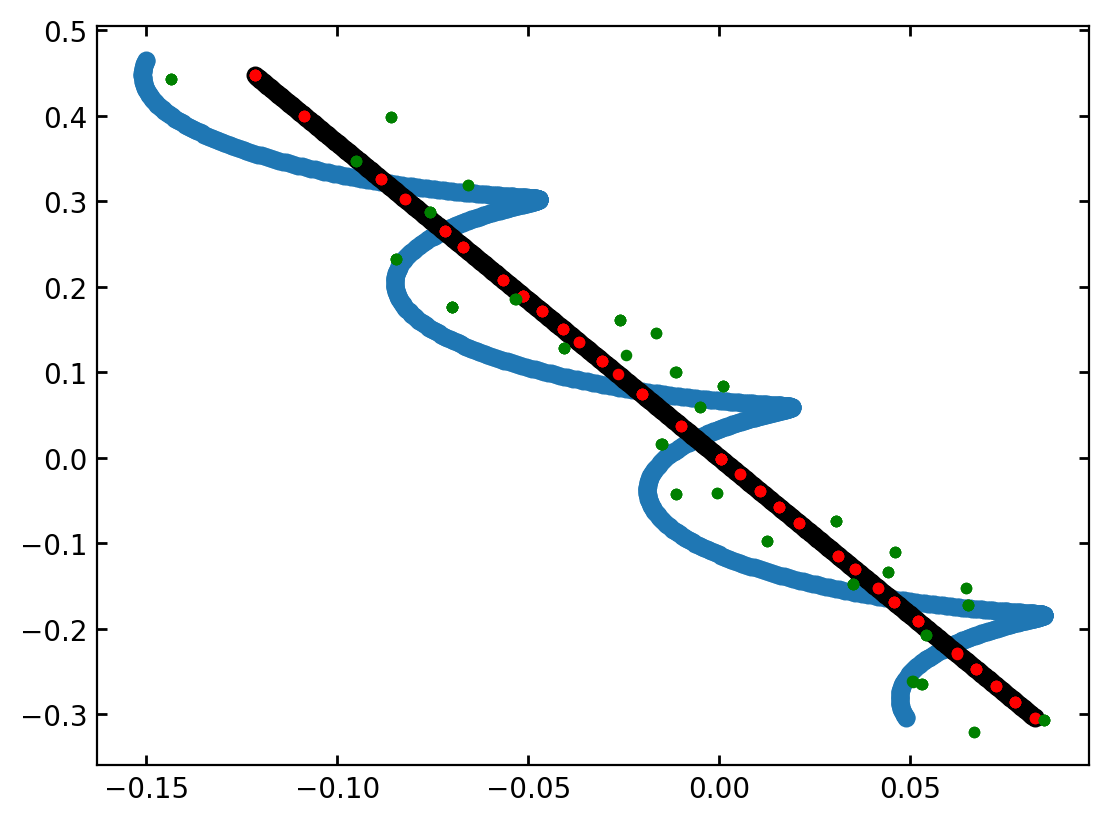

In [11]:
def single_star_soln(t, delta_ra, delta_dec, pm_ra, pm_dec, parallax, pf, spsi,cpsi):
    single_ra = (pm_ra*t/yr)*cpsi + delta_ra + parallax*pf*cpsi
    single_dec = (pm_dec*t/yr)*spsi + delta_dec + parallax*pf*spsi
    tot = ((pm_ra*t/yr)*spsi + (pm_dec*t/yr)*cpsi) + parallax*pf
    return tot
tot_meansoln = single_star_soln(t, 0.0, 0.0, pm_ra, pm_dec, plx, pf, spsi, cpsi)
plt.scatter((pm_ra*fine_t/yr)+ plx*st, (pm_dec*fine_t/yr)+ plx*ct,s=30)
plt.scatter(pm_ra*(fine_t)/yr, pm_dec*(fine_t)/yr,s=30,c='k')
plt.scatter(pm_ra*(t)/yr, pm_dec*(t)/yr,s=10,c='r')
plt.scatter(pm_ra*(t)/yr + plx*pf*spsi, pm_dec*(t)/yr + plx*pf*cpsi,s=10,c='green')

In [24]:
mstar = 2.0 # solar masses
rstar = 1.6 # solar radii; in exoplanet, both mstar and rstar are required, but rstar is inconsequential here

In [25]:
def model(t, pf, spsi,cpsi, w, sig_w):

    ### Proper motion + parallax modeling ###

    # Stellar position offest
    delta_ra = numpyro.sample('delta_ra',dist.Normal(0., 0.2)) # ra*cos(dec), arcsec
    delta_dec = numpyro.sample('delta_dec',dist.Normal(0., 0.2)) # dec, arcsec

    # Stellar proper motion
    pm_ra = numpyro.sample('pm_ra',dist.Normal(0., 0.2)) # ra*cos(dec), arcsec/yr
    pm_dec = numpyro.sample('pm_dec',dist.Normal(0., 0.2)) # dec, arcsec/yr
    # Parallax
    log_parallax = numpyro.sample('log_parallax', dist.Normal(jnp.log(0.033), 5.0)) #arcsec
    parallax = numpyro.deterministic('parallax',jnp.exp(log_parallax)) # arcsec
    # Astrometric jitter
    log_sigma = numpyro.sample('log_sigma',dist.Normal(0.0,1.0))
    # Model prediction
    def single_star_as(t, delta_ra, delta_dec, pm_ra, pm_dec, parallax, pf, spsi,cpsi):
        single_ra = numpyro.deterministic('single_ra', pm_ra*t/yr + delta_ra + parallax*pf*spsi)
        single_dec = numpyro.deterministic('single_dec', pm_dec*t/yr + delta_dec + parallax*pf*cpsi)
        return (pm_ra*t/yr+delta_ra)*spsi + (pm_dec*t/yr+delta_dec)*cpsi + (parallax*pf)
    
    model_single = numpyro.deterministic('model_single', single_star_as(t, delta_ra, delta_dec, pm_ra, pm_dec, parallax, pf, spsi,cpsi))
    ### Binary modeling ###

    # Companion mass
    log_mp = numpyro.sample("log_mp", dist.Uniform(jnp.log(1e-3), jnp.log(1e3))) # solar masses
    mp = numpyro.deterministic('mp', jnp.exp(log_mp))

    #stellar mass
    ms = numpyro.sample('ms',dist.Normal(2.0,0.3))

    # Period
    #log_p = numpyro.sample('log_p', dist.Uniform(jnp.log(1e2),jnp.log(1e4))) # days
    p = numpyro.sample('p', dist.Normal(1300,13))

    # Time of periastron passage
    phase_peri = numpyro.sample('phase_peri', dist.Uniform(-0.5,0.5))
    tp = numpyro.deterministic('tp', phase_peri*p)

    # Eccentricity and argument of periastron
    #hk = numpyro.sample('hk', distx.UnitDisk())
    ecc = numpyro.sample('ecc',dist.Normal(0.36,0.03))#numpyro.deterministic('ecc', hk[0]**2 + hk[1]**2)
    omega = numpyro.sample('omega', distx.Angle())#numpyro.deterministic('omega', jnp.arctan2(hk[1], hk[0]))

    # Inclination
    cosi = numpyro.sample('cosi', dist.Uniform(-1.,1.)) # known retrograde orbit
    i = numpyro.deterministic('i', jnp.arccos(cosi))

    # Longitude of ascending node
    long_peri = numpyro.sample('long_peri', distx.Angle())

    # Define the orbit

    host = Central(mass=ms,radius=rstar)
    system = System(host).add_body(period=p,mass=mp,time_peri=tp,inclination=i,eccentricity=ecc,omega_peri=omega,asc_node=long_peri,parallax=parallax)
    def binary_as(t, system):
        xs, ys, zs = system.central_position(t)

        ra = numpyro.deterministic('ra', ys.magnitude[0])
        dec = numpyro.deterministic('dec', xs.magnitude[0])

        # ys in RA direction and xs in Dec direction
        return (ys.magnitude[0]*spsi + xs.magnitude[0]*cpsi)
    
    model_binary = numpyro.deterministic('model_binary', binary_as(t, system))
    # Likelihood
    numpyro.sample('logl', dist.Normal(model_single + model_binary, jnp.sqrt(sig_w**2 + jnp.exp(log_sigma)**2)), obs=w)
    # For plotting
    t_plot = jnp.linspace(0, 5000, 1000)
    xs_plot, ys_plot, _ = system.central_position(t_plot)
    ra_plot = numpyro.deterministic('ra_plot', ys_plot.magnitude[0])
    dec_plot = numpyro.deterministic('dec_plot', xs_plot.magnitude[0])

In [27]:
import numpyro_ext.distributions, numpyro_ext.optim


run_optim = numpyro_ext.optim.optimize(model, return_info=True)


opt_params, status = run_optim(jax.random.PRNGKey(2), t, pf, spsi,cpsi, w+tot_meansoln, sig_w)

In [28]:
opt_params

{'delta_ra': Array(0.01951282, dtype=float64),
 'delta_dec': Array(-0.00615884, dtype=float64),
 'pm_ra': Array(-0.08060738, dtype=float64),
 'pm_dec': Array(0.26879615, dtype=float64),
 'log_parallax': Array(-3.36666223, dtype=float64),
 'log_sigma': Array(-5.50299212, dtype=float64),
 'log_mp': Array(-0.32556832, dtype=float64),
 'ms': Array(2., dtype=float64),
 'p': Array(1303.41408055, dtype=float64),
 'phase_peri': Array(0.3618992, dtype=float64),
 'ecc': Array(0.29986544, dtype=float64),
 'omega': Array(2.56325244, dtype=float64),
 'cosi': Array(-1., dtype=float64),
 'long_peri': Array(-1.55803279, dtype=float64),
 'dec': Array([ 0.03369951,  0.03369951,  0.03389201,  0.03389201,  0.03389201,
         0.03389201,  0.03369786,  0.03369192,  0.03369192,  0.03310241,
         0.03310241,  0.03310241,  0.03310241,  0.03223719,  0.0322208 ,
         0.0322208 ,  0.0294963 ,  0.0294963 ,  0.0294963 ,  0.0294963 ,
         0.02733315,  0.02733315,  0.02733315,  0.02733315,  0.0256442 ,


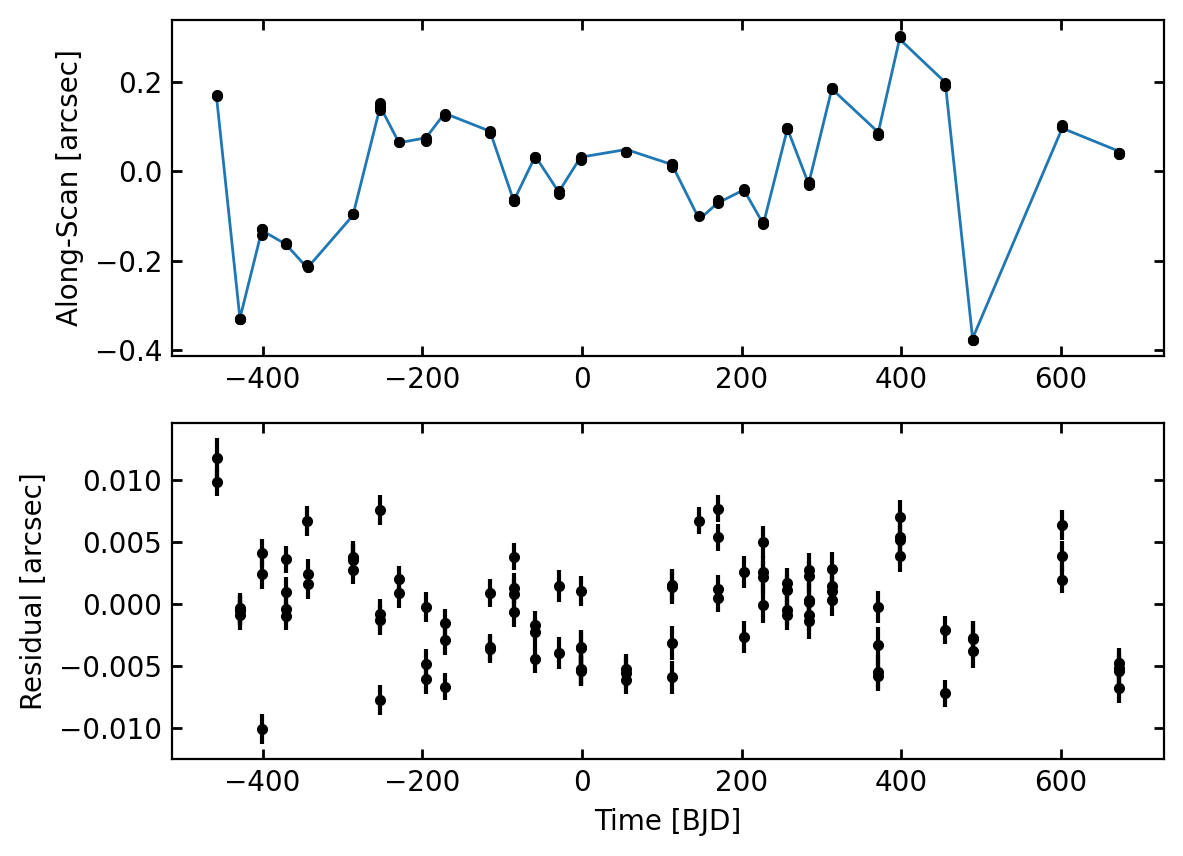

In [29]:
plt.figure()

plt.subplot(2,1,1)
plt.errorbar(t, w+tot_meansoln, yerr=sig_w, fmt='o', ms=3, c='k')
plt.plot(t, opt_params['model_single'] + opt_params['model_binary'], lw=1)

plt.ylabel('Along-Scan [arcsec]')

plt.subplot(2,1,2)
plt.errorbar(t, w-opt_params['model_single']-opt_params['model_binary']+tot_meansoln, yerr=sig_w, fmt='o', ms=3, c='k')

plt.xlabel('Time [BJD]')
plt.ylabel('Residual [arcsec]')

plt.show()

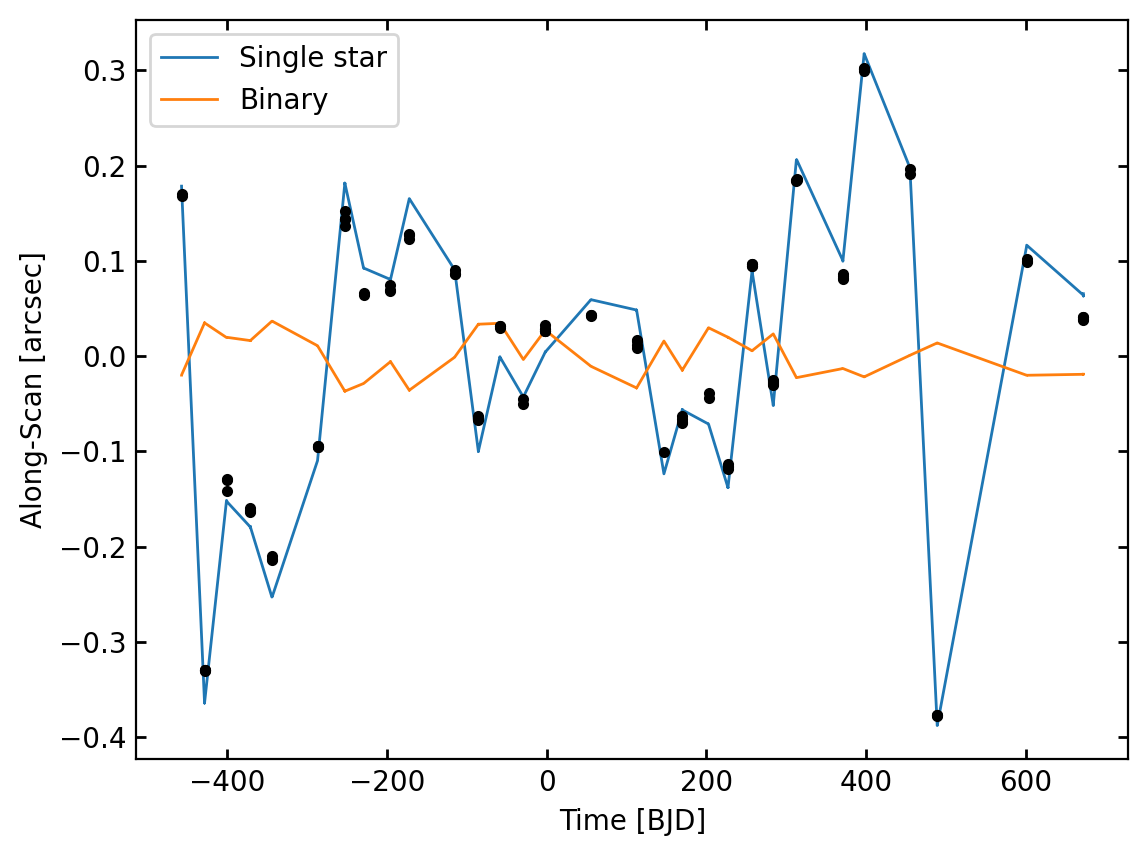

In [30]:
plt.figure()

plt.errorbar(t, w+tot_meansoln, yerr=sig_w, fmt='o', ms=3, c='k')

plt.plot(t, opt_params['model_single'], lw=1, label='Single star')
plt.plot(t, opt_params['model_binary'], lw=1, label='Binary')

plt.ylabel('Along-Scan [arcsec]')
plt.xlabel('Time [BJD]')

plt.legend()

plt.show()

In [31]:
sampler_wn = infer.MCMC(
    infer.NUTS(
        model,
        target_accept_prob=0.8,
        dense_mass=True,
        init_strategy=infer.init_to_value(values=opt_params),
        regularize_mass_matrix=False,
    ),
    num_warmup=4000,
    num_samples=8000,
    num_chains=2,
    progress_bar=True,
)
%time sampler_wn.run(jax.random.PRNGKey(11), t, pf, spsi,cpsi, w+tot_meansoln, sig_w)

/var/folders/4b/sq0slnz147sfy_kz1_nwf6zh0000gn/T/ipykernel_179/3315277478.py:1: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_wn = infer.MCMC(
sample: 100%|██████████| 12000/12000 [00:19<00:00, 622.78it/s, 31 steps of size 1.65e-01. acc. prob=0.77]


CPU times: user 46.9 s, sys: 806 ms, total: 47.7 s
Wall time: 47.7 s


In [32]:
import arviz as az
inf_data_wn = az.from_numpyro(sampler_wn)
az.summary(inf_data_wn, var_names=['delta_ra', 'delta_dec', 'pm_ra', 'pm_dec', 'log_parallax', 'parallax', 'log_sigma', 'log_mp', 'mp','ms', 'p', 'ecc', 'omega', 'cosi', 'i', 'long_peri', 'tp'], 
           round_to=8)

mean         sd       hdi_3%      hdi_97%  mcse_mean   
delta_ra         0.018596   0.002275     0.014381     0.022796   0.000055  \
delta_dec        0.000447   0.001529    -0.002503     0.003214   0.000061   
pm_ra           -0.080372   0.001810    -0.083607    -0.076888   0.000034   
pm_dec           0.290097   0.004090     0.282741     0.297826   0.000100   
log_parallax    -3.391543   0.016189    -3.422058    -3.361058   0.000226   
parallax         0.033661   0.000545     0.032645     0.034699   0.000008   
log_sigma       -5.769662   0.093634    -5.944826    -5.591481   0.001966   
log_mp           0.459313   0.155731     0.175280     0.750879   0.003197   
mp               1.602339   0.251861     1.170759     2.088585   0.004865   
ms               1.987076   0.305592     1.378810     2.537737   0.005549   
p             1293.687992  13.052061  1269.434619  1318.387219   0.229311   
ecc              0.307024   0.031115     0.248002     0.365104   0.000757   
omega            1.542546   0.071746     1.400426     1.661554   0.003031   
cosi            -0.480356   0.040676    -0.556249    -0.402662   0.001053   
i                2.072458   0.046629     1.985220     2.160662   0.001227   
long_peri        2.777207   1.278953     2.957149     3.141537   0.025142   
tp             624.246853  19.204221   585.923757   654.573334   0.881460   

               mcse_sd     ess_bulk     ess_tail     r_hat  
delta_ra      0.000040  1725.102679  1730.602361  1.000798  
delta_dec     0.000043   738.937672   310.779284  1.006656  
pm_ra         0.000024  2795.534873  4957.184069  1.000167  
pm_dec        0.000071  1521.737555  1096.370460  1.000000  
log_parallax  0.000160  5094.338362  6639.272701  1.001414  
parallax      0.000005  5094.338362  6639.272701  1.001414  
log_sigma     0.001405  2375.287863  1220.910430  1.001063  
log_mp        0.002261  2322.492200  3912.970862  1.000014  
mp            0.003440  2322.492200  3912.970862  1.000014  
ms            0.003924  3087.277672  1359.932974  1.002700  
p             0.162300  3274.725678  4875.109780  1.000749  
ecc           0.000536  1667.792611  1754.139774  1.000445  
omega         0.002144   711.829197   297.705891  1.005855  
cosi          0.000782  1686.406265   629.926117  1.000537  
i             0.000879  1686.406265   629.926117  1.000546  
long_peri     0.017924  4425.818272  2829.826282  1.000580  
tp            0.623670   649.297499   258.416418  1.004338

In [33]:
np.rad2deg(2.156102), (np.rad2deg(2.156102+0.047149)-np.rad2deg(2.156102-0.047149))

(123.53554479971584, 5.402877416524646)

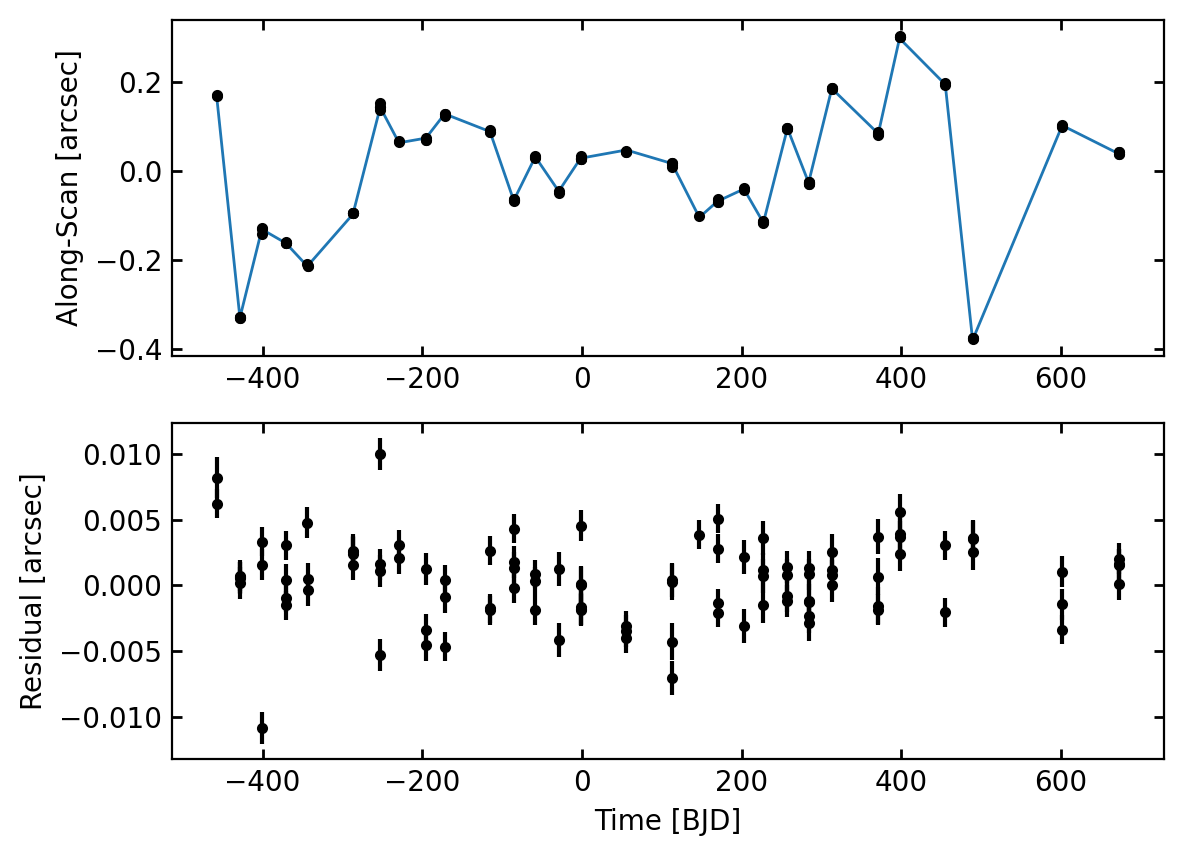

In [34]:
plt.figure()

plt.subplot(2,1,1)
plt.errorbar(t, w+tot_meansoln, yerr=sig_w, fmt='o', ms=3, c='k')

as_pred = inf_data_wn.posterior['model_single'].values + inf_data_wn.posterior['model_binary'].values
q16, q50, q84 = np.percentile(as_pred, [16, 50, 84], axis=(0, 1))

plt.plot(t, q50, lw=1)
plt.fill_between(t, q16, q84, alpha=0.3)

plt.ylabel('Along-Scan [arcsec]')

plt.subplot(2,1,2)
plt.errorbar(t, w-q50+tot_meansoln, yerr=sig_w, fmt='o', ms=3, c='k')

plt.xlabel('Time [BJD]')
plt.ylabel('Residual [arcsec]')

plt.show()

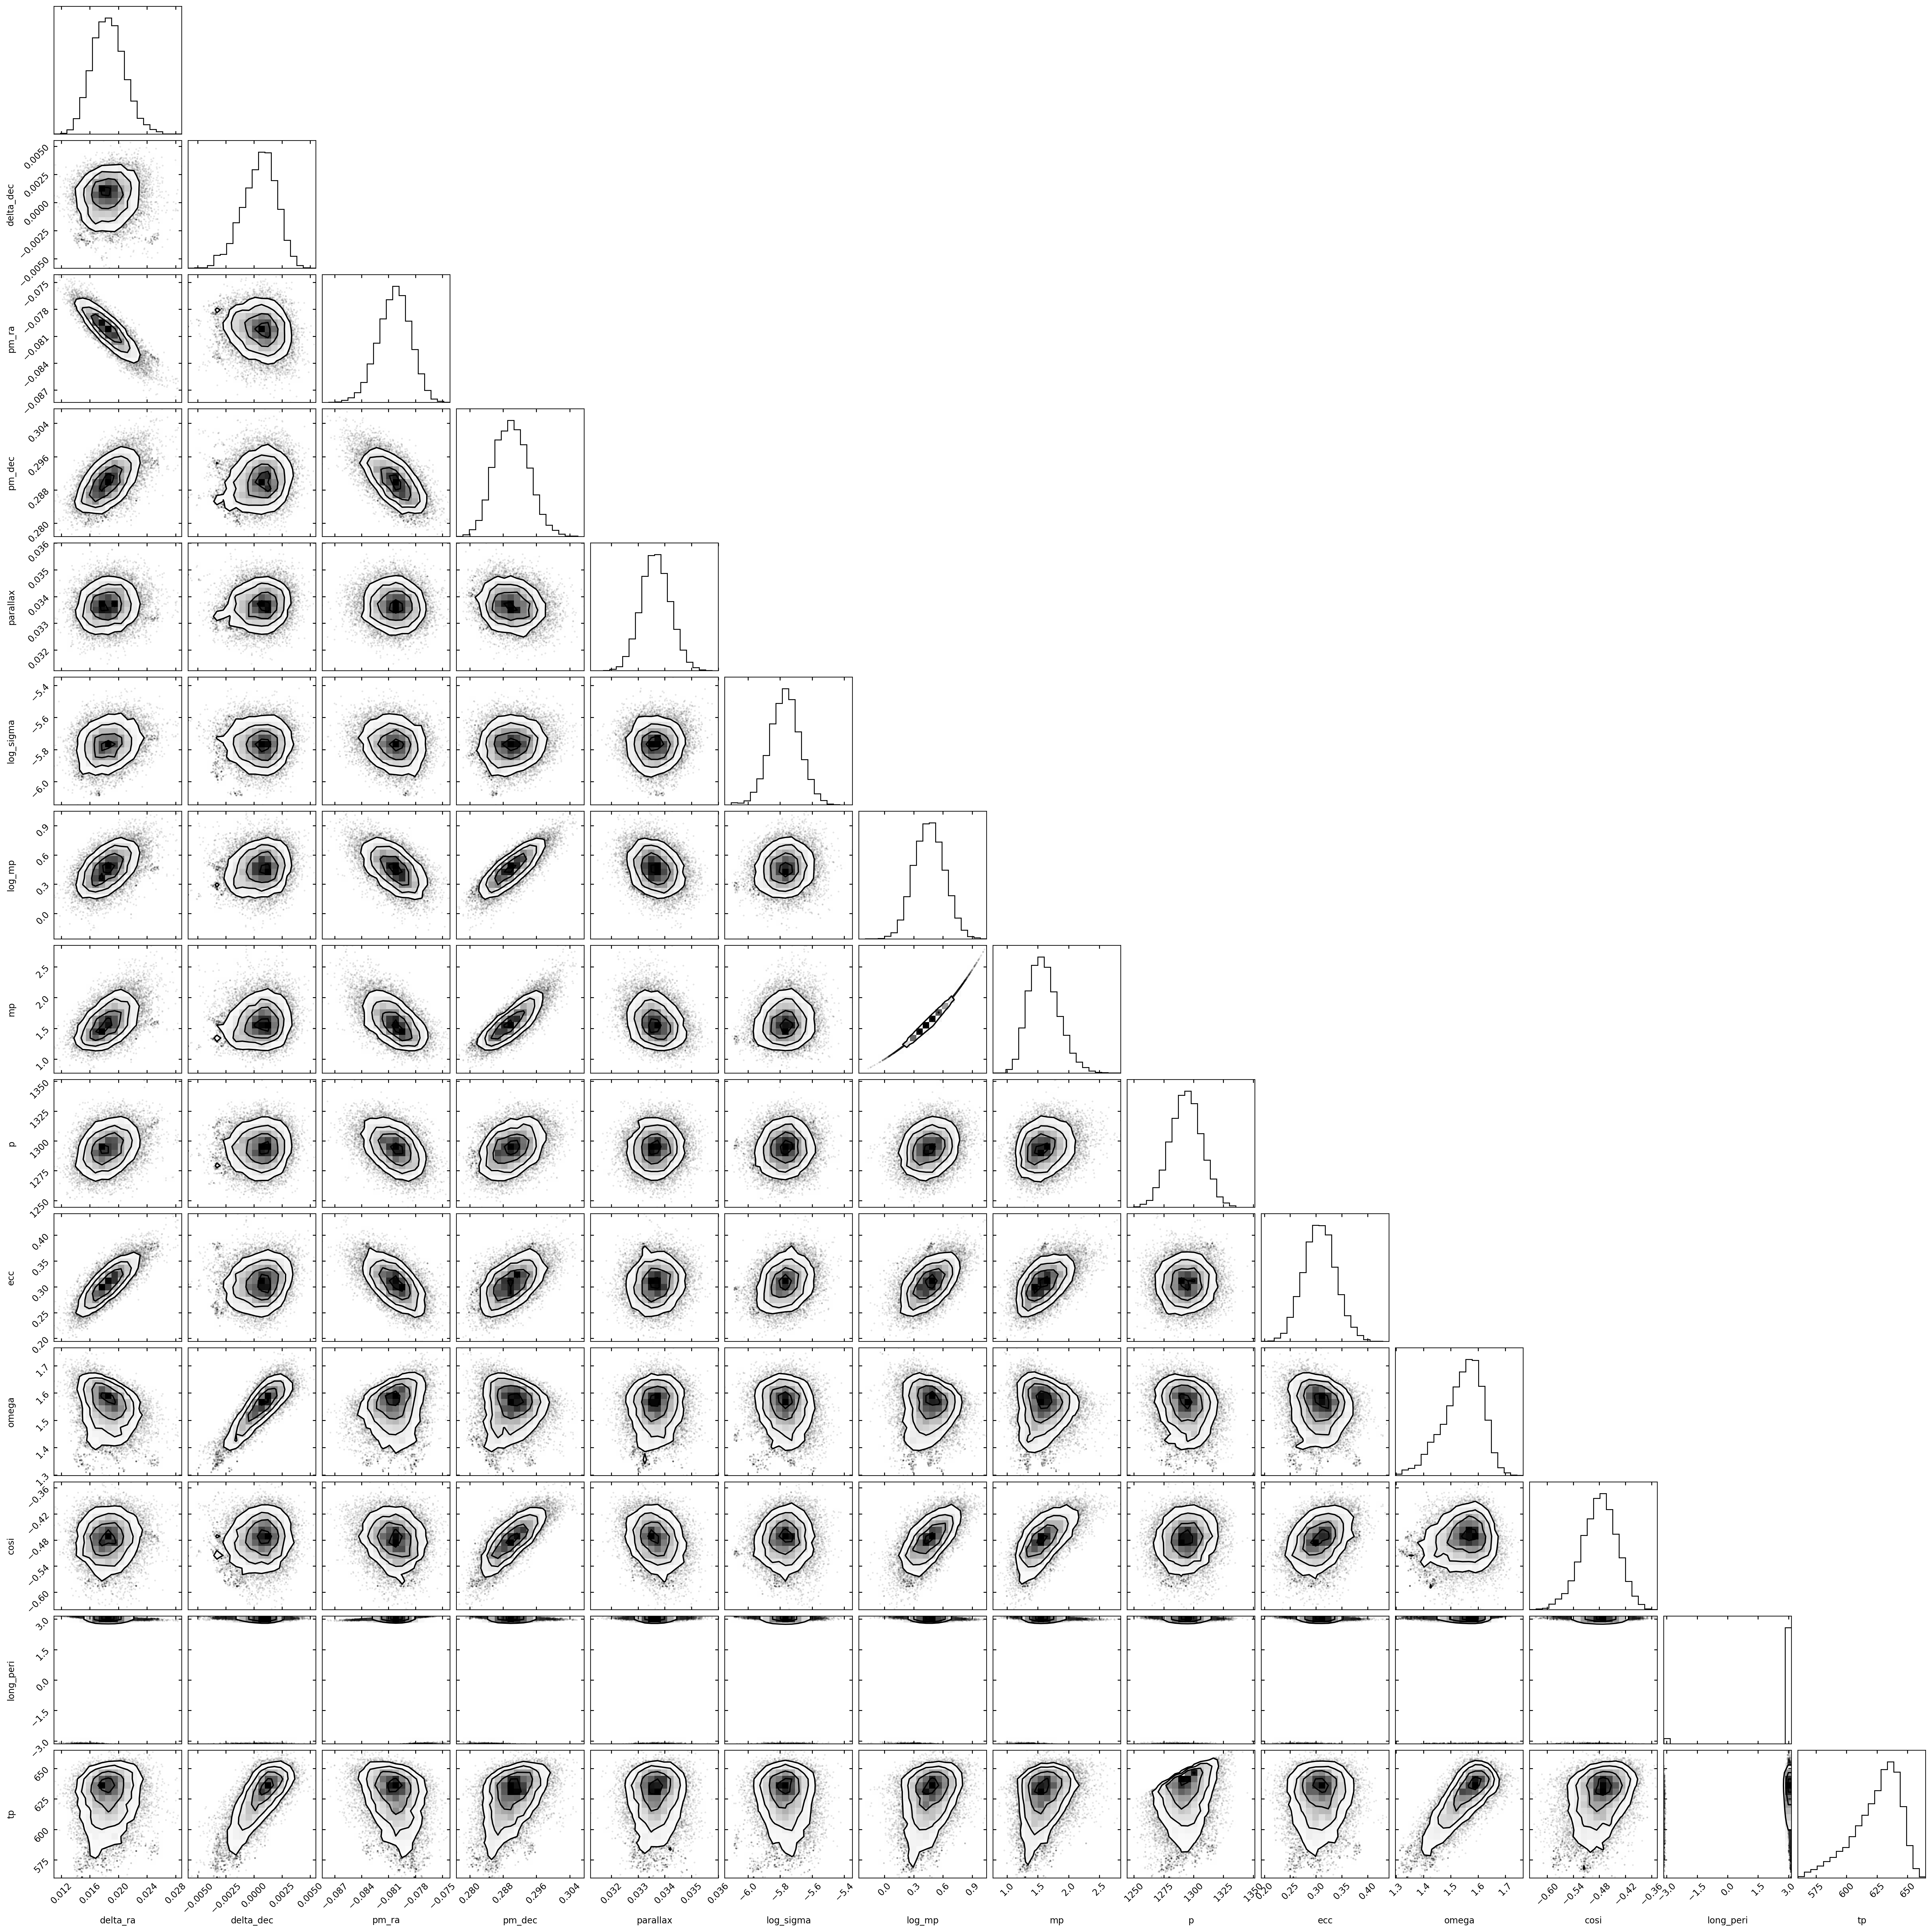

In [35]:
import corner
fig = corner.corner(inf_data_wn.posterior,var_names=['delta_ra', 'delta_dec', 'pm_ra', 'pm_dec', 'parallax', 'log_sigma', 
                         'log_mp', 'mp','p', 'ecc', 'omega', 'cosi', 'long_peri', 'tp']);

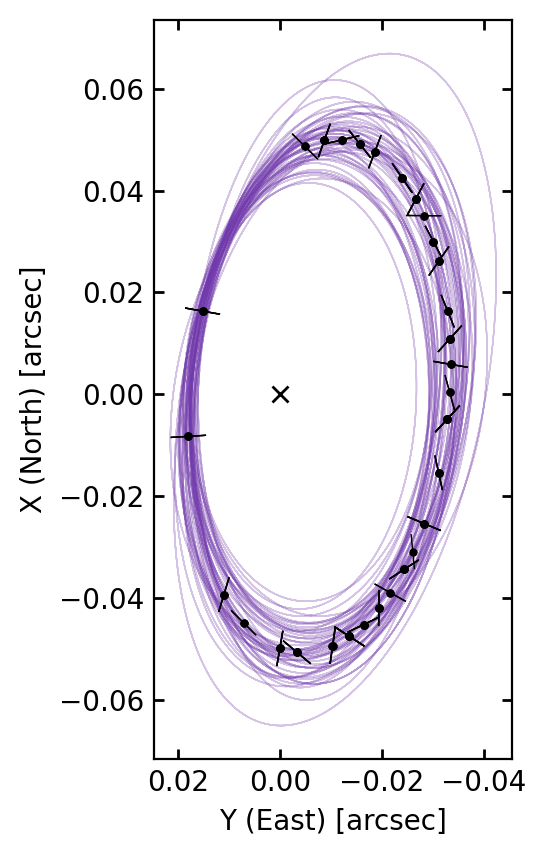

In [36]:
fig = plt.figure()

plt.plot(0, 0, marker='x', c='k')

ra_plot = inf_data_wn.posterior['ra_plot'].values
dec_plot = inf_data_wn.posterior['dec_plot'].values
# 300 draws from the posterior
for i in range(50):
    m = np.random.randint(0, ra_plot.shape[0])
    n = np.random.randint(0, ra_plot.shape[1])
    plt.plot(ra_plot[m,n,:], dec_plot[m,n,:], lw=0.5, c="#7139AC", alpha=0.3)

# plot "data"

jitter = np.exp(np.median(inf_data_wn.posterior.log_sigma.values.flatten()))

for i in range(len(t)):
    this_ra = inf_data_wn.posterior.ra.values[:,:,i].flatten()
    this_dec = inf_data_wn.posterior.dec.values[:,:,i].flatten()

    # median position and uncertainty out of model
    med_ra = np.median(this_ra)
    med_dec = np.median(this_dec)

    sd_ra = np.sqrt(sig_w[i]**2 + jitter**2)*spsi[i]
    sd_dec = np.sqrt(sig_w[i]**2 + jitter**2)*cpsi[i]

    plt.plot([med_ra - sd_ra, med_ra + sd_ra], [med_dec - sd_dec, med_dec + sd_dec], c='k', lw=0.5)      
    plt.plot(med_ra, med_dec, marker='o', linestyle=' ', c='k', ms=2)

plt.xlabel('Y (East) [arcsec]')
plt.ylabel('X (North) [arcsec]')

plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')
#plt.legend()
plt.savefig('alpha_pic_orbit.png', dpi=300,bbox_inches='tight')

In [84]:
inf_data_wn.posterior['ra_plot'].values.shape

(2, 8000, 1000)